# Stokes flow between two plates
***

## Introduction
Stokes equations describe a Newtonian fluid for very small Reynolds number

$$\mathrm{Re} = \frac{\rho L_\mathrm{char} U_\mathrm{char}}{\mu},$$

where $L_\mathrm{char}$ and $U_\mathrm{char}$ are characteristic length and speed, $\mu$ is dynamic viscosity and $\rho$ is density. Stokes equations are suitable for mesoscopic problems and for fluids with high viscosity,  like syrups and molasses. The strong formulation of stationary and incompressible Stokes flow reads

$$ \nabla \cdot \mathbf{u} = 0 $$
$$ -\nabla p + \mu \Delta \mathbf{u} = \mathbf{0}.$$

The system has unkowns $\mathbf{u}$ (velocity) and $p$ (pressure). 

As an educational example, consider two-dimensional flow between two parallel plates separated by distance $2R$. At the inflow (left), there is a rather strange velocity profile described by a quintic polynomial

$$ \mathbf{u}(x,y) = \frac{5}{8} \left(1 - \frac{y}{R} \right) \left( 1 + \frac{y}{R} \right)^4 \, \hat{\mathbf{x}}, \quad (x,y) \in \Gamma_\mathrm{in}.$$

Let there be no slip on the surface of plates (top and bottom)

$$ \mathbf{u}(x,y) = \mathbf{0}, \quad (x,y) \in \Gamma_\mathrm{wall}$$

and outlfow condition (right)

$$ (-p \mathbb{I} + \mu \nabla \mathbf{u}) \mathbf{n} = \mathbf{0}, \quad (x,y) \in \Gamma_\mathrm{out}.$$

What kind of velocity profile will be at the outflow?

![Geometry](fig/plates.png "Geometry")

## Weak formulation

First, we multiply by a pair of test functions $\mathbf{v}, q$ and integrate
$$ \int_\Omega q \nabla \cdot \mathbf{u} \; \mathrm{d}\mathbf{x} = 0, $$
$$ \int_\Omega (-\mu \Delta \mathbf{u} + \nabla p) \cdot \mathbf{v} \; \mathrm{d}\mathbf{x} = 0. $$

We impose that $\mathbf{v}$ vanishes on both Dirichlet boundaries $\Gamma_\mathrm{in}$, $\Gamma_\mathrm{plates}$. In the next step, we integrate by parts in the second expression to remove second derivatives. By virtue of boundary conditions, no surface integrals appear in the process.

$$ \int_\Omega q \nabla \cdot \mathbf{u} \; \mathrm{d}\mathbf{x} = 0, $$
$$ \int_\Omega \left( \mu \nabla \mathbf{u} \cdot \nabla \mathbf{v} - p \nabla \cdot \mathbf{v} \right) \; \mathrm{d}\mathbf{x} = 0. $$

The equations can be added together to obtain a nicely symmetrical form:

$$ \int_\Omega \left( \mu \nabla \mathbf{u} \cdot \nabla \mathbf{v} - p \nabla \cdot \mathbf{v} - q \nabla \cdot \mathbf{u} \right) \; \mathrm{d}\mathbf{x} = 0. $$

Compared to the strong formulation (four scalar equations for every point of $\Omega$) it may seem we lost information. However, this is not true because the functions $q, \mathbf{v}$ were arbitrary (up to the bounary condition imposed and certain integrability assumptions). The finite element method samples $\Omega$ into mesh and replaces $\mathbf{u}, p, \mathbf{v}, q$ with piece-wise polynomial approximations. This leads to a linear system of $N$ equations (for every degree of freedom that *test functions* $\mathbf{v}, q$ have) and $N$ unknowns (for every degree of freedom that *trial functions* $\mathbf{u}, p$ have).

We know how to solve linear systems but calculating it on paper would be a nightmare. It is better to ask FEniCS to do the dirty job.

## FEniCS implementation

Import **dolfin** (FEniCS backend), **matplotlib.pyplot** (for plots), **numpy** (for arrays) and **time** (for benchmarking).

In [22]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
from time import time

Create mesh.

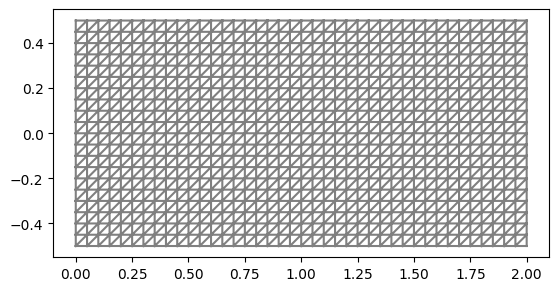

In [23]:
R = 0.5    # half of distance between plates
L = 2.0    # length
n_x = 40   # x-resolution
n_y = 20   # y-resolution
mesh = RectangleMesh(Point(0, -R), Point(L, R), n_x, n_y)

plot(mesh)
plt.show()

Identify boundaries.

In [14]:
# define boundary as a class
class Inflow(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

inflow = Inflow()

# or with AutoSubDomain
outflow = AutoSubDomain(lambda x, on_boundary: on_boundary and near(x[0], L))
walls = AutoSubDomain(lambda x, on_boundary: on_boundary and near(abs(x[1]), R))

# mark boundary parts
bdary = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0)
inflow.mark(bdary, 1)
outflow.mark(bdary, 2)
walls.mark(bdary, 3)

Define mixed function space for pressure and velocity. (In this example, we will use Taylor-Hood elements, which are quadratic in velocity and linear in pressure. There is a deep reason for having extra degrees of freedom in velocity. Mixed spaces with identical finite elements for $u$ a $p$ usually fail as they do not satisfy [Babuška-Brezzi condition](https://en.wikipedia.org/wiki/Ladyzhenskaya%E2%80%93Babu%C5%A1ka%E2%80%93Brezzi_condition).)

In [15]:
Ev = VectorElement("CG", mesh.ufl_cell(), 2) # 2 = quadratic elements
Ep = FiniteElement("CG", mesh.ufl_cell(), 1) # 1 = linear elements
E = MixedElement([Ev, Ep]) # Taylor-Hood mixed element
W = FunctionSpace(mesh, E)

Declare boundary conditions.

In [16]:
v_wall = Constant((0.0, 0.0))
v_inflow = Expression(("5.0/8.0*(1.0 - x[1]/R)*pow(1.0 + x[1]/R, 4)", "0"), degree = 2, R = R) 
bc_wall = DirichletBC(W.sub(0), v_wall, bdary, 3)
bc_inflow = DirichletBC(W.sub(0), v_inflow, bdary, 1)
bc = [bc_inflow, bc_wall]

Write variational formulation.

In [17]:
mu = Constant(1.0)  # dynamic viscosity
f = Constant((0.0, 0.0)) # external force
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = mu*inner(grad(u), grad(v))*dx - p*div(v)*dx - q*div(u)*dx
b = inner(f,v)*dx

Plot sparsity pattern of the linear system. (The matrix is symmetric and sparse like in Poisson problem. However, closer inspection reveals that some diagonal elements are zero. This indicates that the matrix cannot be positive-definite. In fact, it is an example of a *saddle-point* matrix with both positive and negative eigenvalues.)

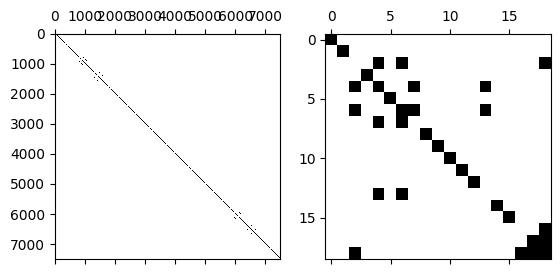

In [18]:
A, _ = assemble_system(a, b, bc)
A = A.array()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(A)
ax2.spy(A[1:20,1:20])
plt.show()

Solve the linear problem using *mumps* direct sparse linear solver.

In [19]:
w = Function(W)
problem = LinearVariationalProblem(a, b, w, bc)
solver = LinearVariationalSolver(problem)
solver.parameters['linear_solver'] = 'mumps'

tick0 = time()
solver.solve()
tick1 = time()
print("elapsed = ", tick1 - tick0)

elapsed =  0.062334537506103516
Solving linear variational problem.


Show results with pyplot.

Plot of u[0] 

Object cannot be plotted directly, projecting to piecewise linears.


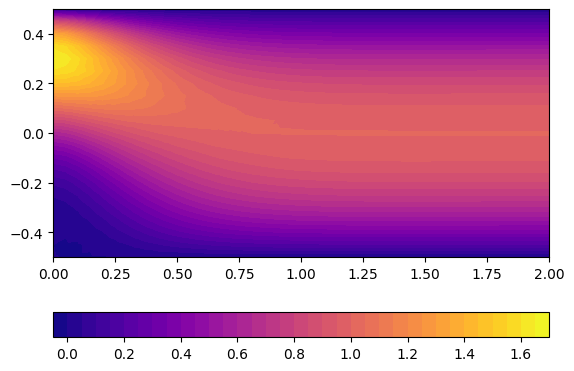

Plot of u[1] 

Object cannot be plotted directly, projecting to piecewise linears.


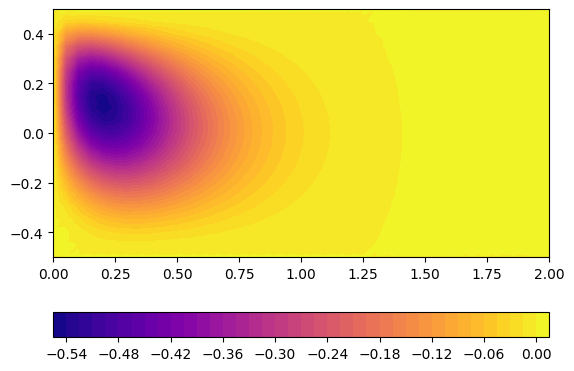

Plot of p 



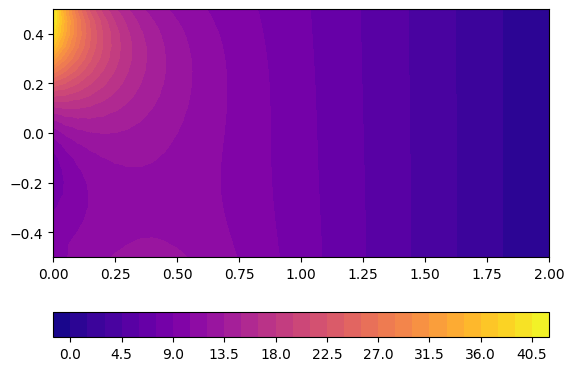

In [26]:
u, p = w.split()
u.rename("u", "velocity")
p.rename("p", "pressure")

for unknown in u[0], u[1], p:
    print("Plot of", unknown, "\n")
    figure = plot(unknown, cmap=plt.cm.plasma)
    plt.colorbar(figure, location='bottom')
    plt.show()

Plot velocity profile at the ouflow. Compare it to a parabolic profile (Poiseuille flow).

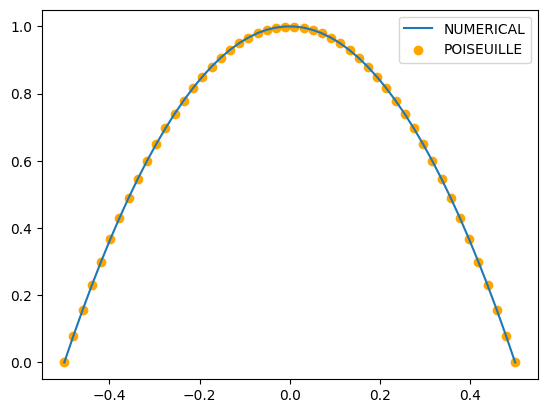

In [21]:
Y = np.linspace(-0.5, 0.5)
U_num = [u(L, y)[0] for y in Y]
U_max = max(U_num)
U_poi = [U_max*(1.0 - (y/R)**2) for y in Y]
plt.plot(Y, U_num, label='NUMERICAL')
plt.scatter(Y, U_poi, label='POISEUILLE', color='orange')
plt.legend()
plt.show()

## Exercises 
1) In the definition of `v_inflow`, why is there `5.0/8.0` and not `5/8`?
2) Can we prevent the emergence of Poiseuille flow by making $\mu$ very small or inflow speed very large?
3) Can we use conjugate gradient method to solve the algebraic system?
4) Try mixed elements other than Tayler-Hood from the list below. (Spoiler: the first  two will not work very well.)
    * CG 1 for velocity, CG 1 for pressure
    * CG 2 for velocity, CG 2 for pressure
    * CG 2 for velocity, DG 0 for pressure (DG stands for Discontinuous Galerkin)
    * CR 1 for velocity, DG 0 for pressure (CR stands for Crouzeix-Raviart)
5) Experiment with different inflow conditions and non-zero external forces.

## Complete code

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
from time import time


# Create mesh.

R = 0.5    # half of distance between plates
L = 2.0    # length
n_x = 40   # x-resolution
n_y = 20   # y-resolution
mesh = RectangleMesh(Point(0, -R), Point(L, R), n_x, n_y)

plot(mesh)
plt.show()


# Identify boundaries.

# define boundary as a class
class Inflow(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

inflow = Inflow()

# or with AutoSubDomain
outflow = AutoSubDomain(lambda x, on_boundary: on_boundary and near(x[0], L))
walls = AutoSubDomain(lambda x, on_boundary: on_boundary and near(abs(x[1]), R))

# mark boundary parts
bdary = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0)
inflow.mark(bdary, 1)
outflow.mark(bdary, 2)
walls.mark(bdary, 3)


# Define mixed function space for pressure and velocity.

Ev = VectorElement("CG", mesh.ufl_cell(), 2) # 2 = quadratic elements
Ep = FiniteElement("CG", mesh.ufl_cell(), 1) # 1 = linear elements
E = MixedElement([Ev, Ep]) # Taylor-Hood mixed element
W = FunctionSpace(mesh, E)


# Declare boundary conditions.

v_wall = Constant((0.0, 0.0))
v_inflow = Expression(("5.0/8.0*(1.0 - x[1]/R)*pow(1.0 + x[1]/R, 4)", "0"), degree = 2, R = R) 
bc_wall = DirichletBC(W.sub(0), v_wall, bdary, 3)
bc_inflow = DirichletBC(W.sub(0), v_inflow, bdary, 1)
bc = [bc_inflow, bc_wall]


# Write variational formulation.

mu = Constant(1.0)  # dynamic viscosity
f = Constant((0.0, 0.0)) # external force
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = mu*inner(grad(u), grad(v))*dx - p*div(v)*dx - q*div(u)*dx
b = inner(f,v)*dx


# Plot sparsity pattern of the linear system.

A, _ = assemble_system(a, b, bc)
A = A.array()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(A)
ax2.spy(A[1:20,1:20])
plt.show()


# Solve the linear problem using *mumps* direct sparse linear solver.

w = Function(W)
problem = LinearVariationalProblem(a, b, w, bc)
solver = LinearVariationalSolver(problem)
solver.parameters['linear_solver'] = 'mumps'

tick0 = time()
solver.solve()
tick1 = time()
print("elapsed = ", tick1 - tick0)


# Show results with pyplot.

u, p = w.split()
u.rename("u", "velocity")
p.rename("p", "pressure")

for unknown in u[0], u[1], p:
    print("Plot of", unknown, "\n")
    figure = plot(unknown)
    plt.colorbar(figure, location='bottom')
    plt.show()


# Plot velocity profile at the ouflow. Compare it to a parabolic profile (Poiseuille flow).

Y = np.linspace(-0.5, 0.5)
U_num = [u(L, y)[0] for y in Y]
U_max = max(U_num)
U_poi = [U_max*(1.0 - (y/R)**2) for y in Y]
plt.plot(Y, U_num, label='NUMERICAL')
plt.scatter(Y, U_poi, label='POISEUILLE', color='orange')
plt.legend()
plt.show()